<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Create-the-dataset" data-toc-modified-id="Create-the-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create the dataset</a></span></li><li><span><a href="#Create-neural-network" data-toc-modified-id="Create-neural-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create neural network</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create the dataset

In [302]:
z = np.linspace(0, 1, 20)
z_plot = np.linspace(0, 1, 21)

In [403]:
def get_y(x1, x2, x3):
    x1 = np.atleast_1d(x1); x2 = np.atleast_1d(x2); x3 = np.atleast_1d(x3)
    tmp =  (x1.reshape(x1.shape[0], 1) * np.sin(1 * np.pi * z.reshape(1, 20)) + 
            x2.reshape(x1.shape[0], 1) * np.sin(4 * np.pi * z.reshape(1, 20)) + 
            x3.reshape(x1.shape[0], 1) * np.sin(5 * np.pi * z.reshape(1, 20)))
    tmp = (tmp.T - np.mean(tmp, axis=1)).T
    rain = np.maximum(0, np.sum(tmp[:, 10:], axis=1).reshape((-1, 1))) * 10
    tmp[:, 10:] =  tmp[:, 10:] - (rain / 10.)
    return np.concatenate([tmp, rain], axis=1)

In [404]:
# create sample data
n_samples = 10000
x1 = np.random.normal(size=n_samples)
x2 = np.random.normal(size=n_samples)
x3 = np.random.normal(size=n_samples)
y = get_y(x1, x2, x3)

In [405]:
y.shape

(10000, 21)

(1.3322676295501878e-15, 0.50003417419677731)

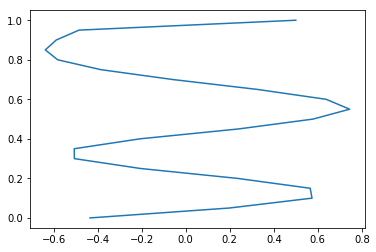

In [417]:
i = np.random.randint(0, n_samples)
plt.plot(y[i], z_plot);
np.sum(y[i]), y[i, -1]

(array([  6.58700000e+03,   1.34200000e+03,   1.03100000e+03,
          5.70000000e+02,   2.83000000e+02,   1.33000000e+02,
          4.60000000e+01,   7.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.34799367,  0.69598735,  1.04398102,  1.3919747 ,
         1.73996837,  2.08796205,  2.43595572,  2.78394939,  3.13194307,
         3.47993674]),
 <a list of 10 Patch objects>)

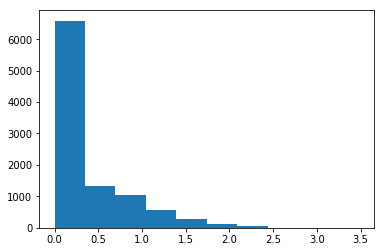

In [418]:
plt.hist(y[:, -1])

In [419]:
# Create test and valid data
x = np.stack([x1, x2, x3], axis=1)
# Add noise to xs
x += (np.random.rand(x.shape[0], x.shape[1]) - 0.2) * 0.6

In [420]:
i_split = int(0.8*n_samples)

In [421]:
x_train = x[:i_split]
y_train = y[:i_split]
x_valid = x[i_split:]
y_valid = y[i_split:]

## Create neural network 

In [422]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [423]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [424]:
model = Sequential([
    Dense(200, input_shape=(3,), activation='relu'),
    Dense(200, activation='relu'),
    Dense(21)
])

In [425]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 200)               800       
_________________________________________________________________
dense_59 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_60 (Dense)             (None, 21)                4221      
Total params: 45,221
Trainable params: 45,221
Non-trainable params: 0
_________________________________________________________________


In [426]:
model.compile(Adam(0.001), 'mse')

In [427]:
model.fit(x_train, y_train, batch_size=512, epochs=10, validation_data=(x_valid, y_valid))

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 0s - loss: 0.7228 - val_loss: 0.3896
Epoch 2/10
8000/8000 [==============================] - 0s - loss: 0.1559 - val_loss: 0.0589
Epoch 3/10
8000/8000 [==============================] - 0s - loss: 0.0538 - val_loss: 0.0405
Epoch 4/10
8000/8000 [==============================] - 0s - loss: 0.0375 - val_loss: 0.0352
Epoch 5/10
8000/8000 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0327
Epoch 6/10
8000/8000 [==============================] - 0s - loss: 0.0322 - val_loss: 0.0318
Epoch 7/10
8000/8000 [==============================] - 0s - loss: 0.0314 - val_loss: 0.0314
Epoch 8/10
8000/8000 [==============================] - 0s - loss: 0.0310 - val_loss: 0.0311
Epoch 9/10
8000/8000 [==============================] - 0s - loss: 0.0307 - val_loss: 0.0310
Epoch 10/10
8000/8000 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0307


In [428]:
y_pred = model.predict(x_valid)

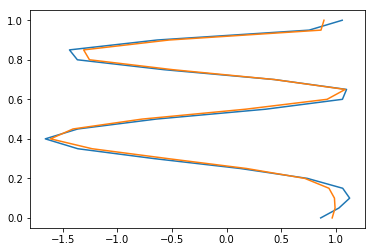

In [438]:
i = np.random.randint(0, n_samples*0.2)
plt.plot(y_valid[i], z_plot, label='true')
plt.plot(y_pred[i], z_plot, label='pred')

In [439]:
np.mean(np.abs(np.mean(y_pred[:, :], axis=1))), np.mean(np.abs(np.mean(y_valid[:], axis=1)))

(0.0030373812, 5.8601506893601888e-17)

In [272]:
import keras.backend as K
def transform(x):
    """x[sample, z-1]"""
    x_last = - K.reshape(K.sum(x, axis=1), (-1, 1))
    return K.concatenate([x, x_last], axis=1)

In [273]:
from keras.losses import mean_squared_error
def transformed_mse(y_true, y_pred):
    return mean_squared_error(y_true, transform(y_pred))

In [274]:
model_transform = Sequential([
    Dense(200, input_shape=(3,), activation='relu'),
    Dense(200, activation='relu'),
    Dense(20-1)
])

In [275]:
model_transform.compile(Adam(0.001), transformed_mse)

In [278]:
model_transform.fit(x_train, y_train, batch_size=512, epochs=10, 
                    validation_data=(x_valid, y_valid))

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s - loss: 0.0606 - val_loss: 0.0579
Epoch 2/10
800/800 [==============================] - 0s - loss: 0.0549 - val_loss: 0.0522
Epoch 3/10
800/800 [==============================] - 0s - loss: 0.0488 - val_loss: 0.0481
Epoch 4/10
800/800 [==============================] - 0s - loss: 0.0442 - val_loss: 0.0458
Epoch 5/10
800/800 [==============================] - 0s - loss: 0.0415 - val_loss: 0.0451
Epoch 6/10
800/800 [==============================] - 0s - loss: 0.0405 - val_loss: 0.0452
Epoch 7/10
800/800 [==============================] - 0s - loss: 0.0400 - val_loss: 0.0453
Epoch 8/10
800/800 [==============================] - 0s - loss: 0.0397 - val_loss: 0.0449
Epoch 9/10
800/800 [==============================] - 0s - loss: 0.0390 - val_loss: 0.0441
Epoch 10/10
800/800 [==============================] - 0s - loss: 0.0380 - val_loss: 0.0430


In [279]:
y_pred_trans = model_transform.predict(x_valid)
y_pred_trans = np.concatenate([y_pred_trans, -y_pred_trans.sum(axis=1).reshape((-1, 1))], axis=1)

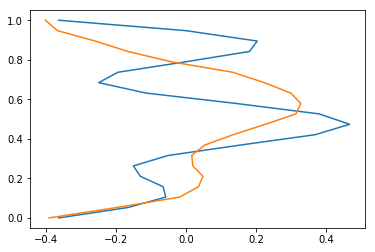

In [280]:
plt.plot(y_valid[2], z, label='true')
plt.plot(y_pred_trans[2], z, label='pred')

In [281]:
y_pred_trans.shape

(200, 20)

In [282]:
np.mean(np.abs(np.mean(y_pred_trans, axis=1))), np.mean(np.abs(np.mean(y_valid, axis=1)))

(0.0, 6.9228477117544427e-17)